In [1]:
using FileIO, DelimitedFiles, Random, Statistics, LinearAlgebra, Images, Flux

In [2]:
numMatRow2Image(matRow) = Gray.(reshape(matRow,(30,20)))


numMatRow2Image (generic function with 1 method)

In [3]:
CuCurrent3_HallVoltage_dat_x=[(open("data/exported_data/CuCurrent3_HallVoltage_"*string(i)*".tsv","r") do io readdlm(io) end) for i in 1:6];
CuCurrent3_HallVoltage_X = reduce(vcat,CuCurrent3_HallVoltage_dat_x);
CuCurrent3_HallVoltage_dat_labels=[(open("data/exported_data/CuCurrent3_HallVoltage_"*string(i)*"labels.tsv","r") do io readdlm(io) end) for i in 1:6];


CuCurrent3_HallVoltage_labelled_Y[ind] = 3


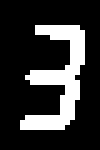

In [5]:
CuCurrent3_HallVoltage_labelled_X = vcat((CuCurrent3_HallVoltage_dat_x[i][Int64.(CuCurrent3_HallVoltage_dat_labels[i][:,1]),:] for i in eachindex(CuCurrent3_HallVoltage_dat_labels))...) #[1,:] |> numMatRow2Image;
CuCurrent3_HallVoltage_labelled_Y = vcat(CuCurrent3_HallVoltage_dat_labels...)[:,2] |> X -> replace(X,"-"=>-1) |> Vector{Int64};

let ind = rand(1:600)
    @show CuCurrent3_HallVoltage_labelled_Y[ind]
    CuCurrent3_HallVoltage_labelled_X[ind,:] |> numMatRow2Image
end


### Trans current:


CuCurrent3_TransverseCurrent_labelled_Y[ind] = 3


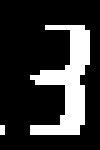

In [5]:
CuCurrent3_TransverseCurrent_dat_x=[(open("data/exported_data/CuCurrent3_TransverseCurrent_"*string(i)*".tsv","r") do io readdlm(io) end) for i in 1:4];
CuCurrent3_TransverseCurrent_X = reduce(vcat,CuCurrent3_TransverseCurrent_dat_x);
CuCurrent3_TransverseCurrent_dat_labels=[(open("data/exported_data/CuCurrent3_TransverseCurrent_"*string(i)*"labels.tsv","r") do io readdlm(io) end) for i in 1:4];
CuCurrent3_TransverseCurrent_labelled_X = vcat((CuCurrent3_TransverseCurrent_dat_x[i][Int64.(CuCurrent3_TransverseCurrent_dat_labels[i][:,1]),:] for i in eachindex(CuCurrent3_TransverseCurrent_dat_labels))...) #[1,:] |> numMatRow2Image;
CuCurrent3_TransverseCurrent_labelled_Y = vcat(CuCurrent3_TransverseCurrent_dat_labels...)[:,2] |> X -> replace(X,"-"=>-1) |> Vector{Int64};
let ind = rand(1:1000)
    @show CuCurrent3_TransverseCurrent_labelled_Y[ind]
    CuCurrent3_TransverseCurrent_labelled_X[ind,:] |> numMatRow2Image
end



In [6]:
CuCurrent3_TransverseCurrent_trainIndices = shuffle(eachindex(CuCurrent3_TransverseCurrent_labelled_Y))[1:800];
CuCurrent3_TransverseCurrent_train_X = CuCurrent3_TransverseCurrent_labelled_X[CuCurrent3_TransverseCurrent_trainIndices,:];
CuCurrent3_TransverseCurrent_train_Y = CuCurrent3_TransverseCurrent_labelled_Y[CuCurrent3_TransverseCurrent_trainIndices];

CuCurrent3_TransverseCurrent_testIndices = eachindex(CuCurrent3_TransverseCurrent_labelled_Y) .|> X-> !any(X .∈ CuCurrent3_TransverseCurrent_trainIndices);
CuCurrent3_TransverseCurrent_test_X = CuCurrent3_TransverseCurrent_labelled_X[CuCurrent3_TransverseCurrent_testIndices,:];
CuCurrent3_TransverseCurrent_test_Y = CuCurrent3_TransverseCurrent_labelled_Y[CuCurrent3_TransverseCurrent_testIndices];


CuCurrent3_TransverseCurrent_train_Y[ind] = 9


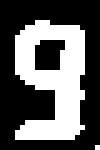

In [15]:
let ind=rand(1:800)
    @show CuCurrent3_TransverseCurrent_train_Y[ind]
    CuCurrent3_TransverseCurrent_train_X[ind,:] |> numMatRow2Image;
end

CuCurrent3_TransverseCurrent_test_Y[ind] = 4


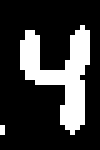

In [15]:
let ind=rand(1:100)
    @show CuCurrent3_TransverseCurrent_test_Y[ind]
    CuCurrent3_TransverseCurrent_test_X[ind,:] |> numMatRow2Image;
end

In [360]:
# model = Chain(
#     # Dense(20 * 30 => 256,relu),
#     Dense(20 * 30 => 512,relu),
#     BatchNorm(512),
#     Dense(512 => 128,relu),
#     # Dense(512 => 256,relu),
#     # Dense(256 => 64,relu),
#     Dense(128 => 64,relu),
#     BatchNorm(64),
#     # Dense(64 => 64,relu),
#     # Dense(128 => 128,relu),
#     # Dense(64 => 64,relu),
#     Dense(64 => 64,relu),
#     Dense(64 => 11,relu),
#     softmax
# )

# model = Chain(
#     Dense(20*30 => 64, relu),
#     BatchNorm(64),
#     Dense(64 => 64, relu),
#     # BatchNorm(64),
#     # Dense(64 => 64, relu),
#     # BatchNorm(64),
#     Dense(64 => 64, relu),
#     # Dense(32 => 32, relu),
#     BatchNorm(64),
#     # BatchNorm(11),
#     Dense(64 => 32, relu),
#     Dense(32 => 11, relu),
#     softmax
# )

model = Chain(
    # Dense(20*30 => 64, relu),
    Dense(20*30 => 64, relu),
    # Dense(20*30 => 64, relu),
    BatchNorm(64),
    Dense(64 => 64, relu),
    # BatchNorm(64),
    # Dense(64 => 64, relu),
    # BatchNorm(64),
    Dense(64 => 64, relu),
    # Dense(32 => 32, relu),
    BatchNorm(64),
    # BatchNorm(11),
    Dense(64 => 32, relu),
    Dense(32 => 11, relu),
    softmax
)


Chain(
  Dense(600 => 64, relu),               # 38_464 parameters
  BatchNorm(64),                        # 128 parameters, plus 128
  Dense(64 => 64, relu),                # 4_160 parameters
  Dense(64 => 64, relu),                # 4_160 parameters
  BatchNorm(64),                        # 128 parameters, plus 128
  Dense(64 => 32, relu),                # 2_080 parameters
  Dense(32 => 11, relu),                # 363 parameters
  NNlib.softmax,
)         # Total: 14 trainable arrays, 49_483 parameters,
          # plus 4 non-trainable, 256 parameters, summarysize 195.371 KiB.

In [361]:
# model(CuCurrent3_TransverseCurrent_labelled_X)
loss(dat) = Flux.crossentropy(model(dat[:data]),dat[:label])
# loss(dat) = Flux.logitcrossentropy(model(dat[:data]),dat[:label])
datLoad = Flux.Data.DataLoader((data=transpose(CuCurrent3_TransverseCurrent_train_X),label=(Flux.onehotbatch(CuCurrent3_TransverseCurrent_train_Y,-1:9)));batchsize=500)

┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 300
└ @ MLUtils /Users/emmyb320/.julia/packages/MLUtils/60cvs/src/dataloader.jl:79


MLUtils.DataLoader{NamedTuple{(:data, :label), Tuple{Transpose{Float64, Matrix{Float64}}, Flux.OneHotArray{UInt32, 11, 1, 2, Vector{UInt32}}}}, Random._GLOBAL_RNG}((data = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 1.0], label = Bool[0 0 … 0 0; 0 1 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]), 300, 300, true, false, Random._GLOBAL_RNG())

In [362]:
@time @Flux.epochs 100 Flux.train!(loss, Flux.params(model), datLoad, ADAM())

  2.018579 seconds (256.10 k allocations: 1.131 GiB, 12.40% gc time, 3.38% compilation time)


┌ Info: Epoch 1
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 2
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 3
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 4
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 5
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 6
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 7
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 8
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 9
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 10
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 11
└ @ Main /Users/emmyb320/.julia/packages/F

In [363]:
accuracY(X,Y) = (Flux.onecold((model)(X|>transpose),-1:9) .== Y) |> mean;
accuracY(CuCurrent3_TransverseCurrent_train_X,CuCurrent3_TransverseCurrent_train_Y)

1.0

In [364]:
accuracY(CuCurrent3_TransverseCurrent_test_X,CuCurrent3_TransverseCurrent_test_Y)


1.0

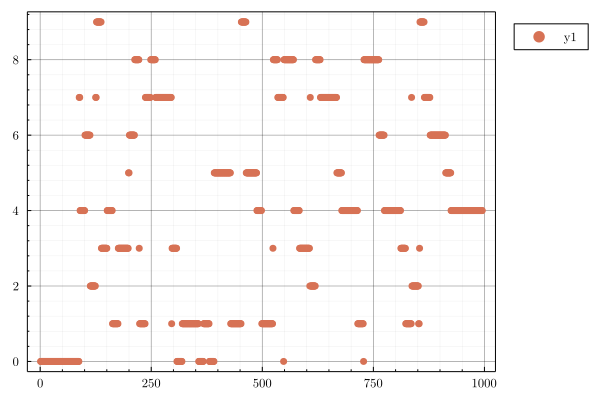

In [365]:
using Plots; theme(:dao)
meow=Flux.onecold(model(transpose(CuCurrent3_TransverseCurrent_dat_x[3])),-1:9);
scatter(meow)

In [366]:
readValues = [(CuCurrent3_TransverseCurrent_dat_x .|> X->Flux.onecold(model(transpose(X)),-1:9))[i] .* [10, 1, 0.1, 0.01][i] for i in 1:4] |> X -> reduce(hcat,X) |> X -> sum(X,dims=2);

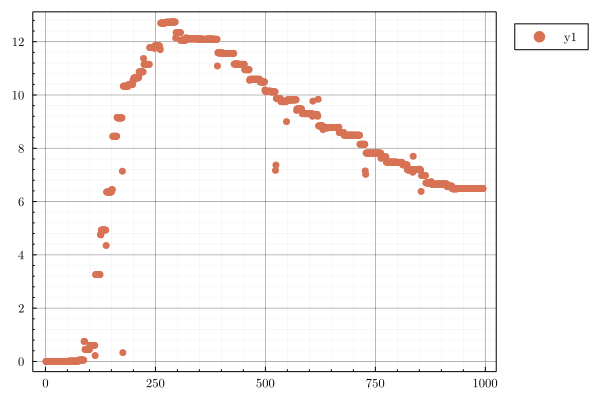

In [368]:
scatter(readValues)